## Columbia University
### ECBM E4040 Neural Networks and Deep Learning. Fall 2021.

# Assignment 1, Task 3: Multilayer Perceptron (MLP)
This is the third part of the assignment. You will get to implement MLP using tensorflow

In [1]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import time
import os
import matplotlib.pyplot as plt
import pickle

from tensorflow.keras.datasets import fashion_mnist

# Plot configurations
%matplotlib inline

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
%load_ext autoreload
%autoreload 2

## Load Data

In [2]:
# Load the raw Fashion-MNIST data.
train, test = fashion_mnist.load_data()

X_train_raw, y_train = train
X_test_raw, y_test = test

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 49000 samples from original train set: 1~49,000
# Validation data: 1000 samples from original train set: 49,000~50,000
# Test data: 10000 samples from original test set: 1~10,000
# Development data (for gradient check): 100 from the train set: 1~49,000
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(49000, 784) (1000, 784) (10000, 784) (100, 784)
Train data shape:  (49000, 784)
Train labels shape:  (49000,)
Validation data shape:  (1000, 784)
Validation labels shape:  (1000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


## Part 1: Tensorflow MLP
In this part, you will use tensorflow modules to implement a MLP. We provide a demo of a two-layer net, of which style is referred to https://www.tensorflow.org/guide/keras, and https://www.tensorflow.org/guide/eager. 

You need to implement a multi-layer with 3 layers in a similar style.

### Demo: Two-layer MLP in Tensorflow

In [3]:
## Demo: Two-layer net in tensorflow (eager execution mode)
hidden_dim = 300
reg_tf = tf.constant(0.01)

# define a tf.keras.Model class
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W1 = tf.Variable(1e-2*np.random.rand(X_train.shape[1], hidden_dim).astype('float32'))
        self.b1 = tf.Variable(np.zeros((hidden_dim,)).astype('float32'))
        self.W2 = tf.Variable(1e-2*np.random.rand(hidden_dim, 20).astype('float32'))
        self.b2 = tf.Variable(np.zeros((20,)).astype('float32'))
    def call(self, inputs):
        """Run the model."""
        h1 = tf.nn.relu(tf.matmul(inputs, self.W1) + self.b1)
        out = tf.matmul(h1, self.W2) + self.b2
        return out

# Define and calculate loss function (Note that in eager execution, loss must be in a function)
def loss(model, inputs, targets, reg = tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= out, labels=tf.one_hot(targets,20))
    L2_loss = tf.nn.l2_loss(model.W1) + tf.nn.l2_loss(model.W2)
    return tf.reduce_mean(cross_entropy) + reg * L2_loss

# calculate gradients for all variables using tf.GradientTape
def grad(model, inputs, targets, reg = tf.constant(0.01)):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, reg=reg)
    return tape.gradient(loss_value, [model.W1, model.b1, model.W2, model.b2])

# calculate classification accuracy
def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.cast(tf.argmax(model(inputs),1), tf.uint8))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

num_train = 49000
batch_size = 500
num_batch = num_train//batch_size
num_epochs = 12
model = Model()
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

for e in range(num_epochs):
    for i in range(num_batch):
        batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        x_tf = tf.Variable(batch_xs, dtype = tf.float32)
        y_tf = tf.Variable(batch_ys, dtype = tf.uint8)
        
        grads = grad(model, x_tf, y_tf, reg_tf)
        #optimization based on calculated gradients 
        optimizer.apply_gradients(zip(grads, [model.W1, model.b1, model.W2, model.b2]))

    x_tf = tf.Variable(X_val, dtype = tf.float32)
    y_tf = tf.Variable(y_val, dtype = tf.uint8)
    accuracy = eval_acc(model, x_tf, y_tf)
    val_acc = accuracy.numpy()
    print('epoch {}: valid acc = {}'.format(e+1, val_acc))

x_tf = tf.Variable(X_test, dtype = tf.float32)
y_tf = tf.Variable(y_test, dtype = tf.uint8)
accuracy = eval_acc(model, x_tf, y_tf)
test_acc = accuracy.numpy()
print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.7429999709129333
epoch 2: valid acc = 0.7789999842643738
epoch 3: valid acc = 0.8220000267028809
epoch 4: valid acc = 0.8389999866485596
epoch 5: valid acc = 0.8429999947547913
epoch 6: valid acc = 0.8529999852180481
epoch 7: valid acc = 0.8610000014305115
epoch 8: valid acc = 0.8619999885559082
epoch 9: valid acc = 0.8640000224113464
epoch 10: valid acc = 0.8659999966621399
epoch 11: valid acc = 0.8709999918937683
epoch 12: valid acc = 0.8730000257492065
test acc = 0.8587999939918518


### Create Deeper Network

<span style="color:red"><strong>TODO</strong></span>: Create your MLP in tensorflow. Since you are going to create a deeper neural network, it is recommended to use "list" to store your network parameters (weights and bias). Consider using a loop to create your MLP network. Hint: Copy the above code and make necessary changes in model definition.

<span style="color:red"><strong>Solution</strong></span>:

In [4]:
hidden_dim = 300
reg_tf = tf.constant(0.01)
num_train = 49000
batch_size = 500
num_batch = num_train//batch_size
num_epochs = 12

W_list = []
b_list = []

netnum_config = [50, 50]
IN_DIM = 784
OUT_DIM = 20


# optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

layer_num = [IN_DIM] + netnum_config + [OUT_DIM]
prior = IN_DIM

for hidden in layer_num[1:]:
    W_list.append(tf.Variable(1e-2*np.random.rand(prior, hidden).astype('float32')))
    b_list.append(tf.Variable(np.zeros((hidden,)).astype('float32')))
    prior = hidden


# Define tf.keras.Model class
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W_list = W_list
        self.b_list = b_list
    def call(self, x):
        for layer,(W,b) in enumerate(zip(self.W_list, self.b_list)):
            if layer < len(netnum_config):
                x = tf.nn.relu(tf.matmul(x, W) + b)
            else:
                x = tf.matmul(x, W) + b
        return x

def loss(model, inputs, targets, reg = tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= out, labels=tf.one_hot(targets,20))
    L2_loss = 0
    for W in model.W_list:
        L2_loss += tf.nn.l2_loss(W)
    return tf.reduce_mean(cross_entropy) + reg * L2_loss

# calculate gradients for all variables using tf.GradientTape
def grad(model, inputs, targets, reg = tf.constant(0.01)):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, reg=reg)
    return tape.gradient(loss_value, model.W_list + model.b_list)

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.cast(tf.argmax(model(inputs),1), tf.uint8))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

model = Model()

for e in range(num_epochs):
    for i in range(num_batch):
        batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        x_tf = tf.Variable(batch_xs, dtype = tf.float32)
        y_tf = tf.Variable(batch_ys, dtype = tf.uint8)
        
        grads = grad(model, x_tf, y_tf, reg_tf)
        #optimization based on calculated gradients 
        optimizer.apply_gradients(zip(grads,  model.W_list + model.b_list))

    x_tf = tf.Variable(X_val, dtype = tf.float32)
    y_tf = tf.Variable(y_val, dtype = tf.uint8)
    accuracy = eval_acc(model, x_tf, y_tf)
    val_acc = accuracy.numpy()
    print('epoch {}: valid acc = {}'.format(e+1, val_acc))

x_tf = tf.Variable(X_test, dtype = tf.float32)
y_tf = tf.Variable(y_test, dtype = tf.uint8)
accuracy = eval_acc(model, x_tf, y_tf)
test_acc = accuracy.numpy()
print('test acc = {}'.format(test_acc))

epoch 1: valid acc = 0.1770000010728836
epoch 2: valid acc = 0.23899999260902405
epoch 3: valid acc = 0.25200000405311584
epoch 4: valid acc = 0.3059999942779541
epoch 5: valid acc = 0.3479999899864197
epoch 6: valid acc = 0.34700000286102295
epoch 7: valid acc = 0.4749999940395355
epoch 8: valid acc = 0.5080000162124634
epoch 9: valid acc = 0.5360000133514404
epoch 10: valid acc = 0.5619999766349792
epoch 11: valid acc = 0.5920000076293945
epoch 12: valid acc = 0.6129999756813049
test acc = 0.5960999727249146


### Introduction to TensorFlow.keras

As you can see, when the network structure becomes larger, it is hard to handle variables from every layer. Here we introduce the `tf.keras` tool to build the network in a much simpler way. You may want to use it in your project.

<span style="color:red"><strong>TODO</strong></span>: Follow this official example: https://www.tensorflow.org/datasets/keras_example#step_2_create_and_train_the_model to build an MLP and train it. 

*You should keep the same optimizer (SGD) and loss function (cross entropy) as in the previous task.*

**Note:** Since we want to use our own dataset, we will not use the `tfds.load` method to load the data this time. 

You need to check the usage of [`model.fit()`](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) and feed the model with our own data.

**Tips:**
* Softmax is also registered as a layer operation in tf.keras.
* You can use `model.summary()` to visualize the model after you build it.
* Use `verbose=2` in `model.fit()` to get similar training logs

<span style="color:red"><strong>SOLUTION</strong></span>:

In [5]:
#############################################################
# TODO: build the model with tf.keras.models.Sequential
hidden_dim = 300
reg_tf = tf.constant(0.01)
num_train = 49000
batch_size = 500
num_batch = num_train//batch_size
num_epochs = 12

W_list = []
b_list = []

netnum_config = [50, 50]
IN_DIM = 784
OUT_DIM = 20


optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

layer_num = [IN_DIM] + netnum_config + [OUT_DIM]
prior = IN_DIM

for hidden in layer_num[1:]:
    W_list.append(tf.Variable(1e-2*np.random.rand(prior, hidden).astype('float32')))
    b_list.append(tf.Variable(np.zeros((hidden,)).astype('float32')))
    prior = hidden


# Define tf.keras.Model class
class Model(tf.keras.Model):
    def __init__(self):
        super(Model, self).__init__()
        self.W_list = W_list
        self.b_list = b_list
    def call(self, x):
        for layer,(W,b) in enumerate(zip(self.W_list, self.b_list)):
            if layer < len(netnum_config):
                x = tf.nn.relu(tf.matmul(x, W) + b)
            else:
                x = tf.matmul(x, W) + b
        return x

# END of your code
#############################################################



#############################################################
# TODO: compile the model, set optimizer and loss
# Define and calculate loss function (Note that in eager execution, loss must be in a function)

def loss(model, inputs, targets, reg = tf.constant(0.01)):
    out = model(inputs)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits= out, labels=tf.one_hot(targets,20))
    L2_loss = 0
    for W in model.W_list:
        L2_loss += tf.nn.l2_loss(W)
    return tf.reduce_mean(cross_entropy) + reg * L2_loss

# calculate gradients for all variables using tf.GradientTape
def grad(model, inputs, targets, reg = tf.constant(0.01)):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, reg=reg)
    return tape.gradient(loss_value, model.W_list + model.b_list)

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)

# END of your code
#############################################################



#############################################################
# TODO: train the model with our own dataset

def eval_acc(model, inputs, targets):
    correct_prediction = tf.equal(targets, tf.cast(tf.argmax(model(inputs),1), tf.uint8))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return accuracy

model = Model()

for e in range(num_epochs):
    for i in range(num_batch):
        batch_xs, batch_ys = X_train[i*batch_size:(i+1)*batch_size], y_train[i*batch_size:(i+1)*batch_size]
        x_tf = tf.Variable(batch_xs, dtype = tf.float32)
        y_tf = tf.Variable(batch_ys, dtype = tf.uint8)
        
        grads = grad(model, x_tf, y_tf, reg_tf)
        #optimization based on calculated gradients 
        optimizer.apply_gradients(zip(grads,  model.W_list + model.b_list))

    x_tf = tf.Variable(X_val, dtype = tf.float32)
    y_tf = tf.Variable(y_val, dtype = tf.uint8)
    accuracy = eval_acc(model, x_tf, y_tf)
    val_acc = accuracy.numpy()
    print('epoch {}: valid acc = {}'.format(e+1, val_acc))

x_tf = tf.Variable(X_test, dtype = tf.float32)
y_tf = tf.Variable(y_test, dtype = tf.uint8)
accuracy = eval_acc(model, x_tf, y_tf)
test_acc = accuracy.numpy()
print('test acc = {}'.format(test_acc))

# END of your code
#############################################################

epoch 1: valid acc = 0.1850000023841858
epoch 2: valid acc = 0.23000000417232513
epoch 3: valid acc = 0.24400000274181366
epoch 4: valid acc = 0.3070000112056732
epoch 5: valid acc = 0.3499999940395355
epoch 6: valid acc = 0.3840000033378601
epoch 7: valid acc = 0.43799999356269836
epoch 8: valid acc = 0.4580000042915344
epoch 9: valid acc = 0.4950000047683716
epoch 10: valid acc = 0.5419999957084656
epoch 11: valid acc = 0.5839999914169312
epoch 12: valid acc = 0.6129999756813049
test acc = 0.5821999907493591


## Part 2: t-SNE (optional, bonus +5 points)

t-SNE is is a machine learning algorithm for nonlinear dimensionality reduction developed by Geoffrey Hinton and Laurens van der Maaten. It is also a good way of visualizing high-dimensional data in 2D. We show its application for CIFAR100. Later it will be re-used in a CNN network. Experimenting with t-SNE can be fun. One thing to try is to visualize the output of each layer of MLP to observe the differences.

<p style="line-height: 1.2;">[1] Maaten, Laurens van der, and Geoffrey Hinton. "Visualizing data using t-SNE." Journal of Machine Learning Research 9.Nov (2008): 2579-2605.</p>
<p style="line-height: 1.2;">[2] Adaptive learning rate scheme by Jacobs https://www.willamette.edu/~gorr/classes/cs449/Momentum/deltabardelta.html</p>
<p style="line-height: 1.2;">[3] http://cs.stanford.edu/people/karpathy/cnnembed/</p>
<p style="line-height: 1.2;">[4] How to Use t-SNE Effectively, with examples.
 https://distill.pub/2016/misread-tsne</p>

In [6]:
from utils.train_funcs import train, test
from utils.classifiers.mlp import MLP
from utils.features.tsne import tsne

In [7]:
# Load the raw Fashion-MNIST data.
train_data, test_data = fashion_mnist.load_data()

X_train_raw, y_train = train_data
X_test_raw, y_test = test_data

X_train = X_train_raw.reshape((X_train_raw.shape[0], X_train_raw.shape[1]**2))
X_test = X_test_raw.reshape((X_test_raw.shape[0], X_test_raw.shape[1]**2))

# Data organizations:
# Train data: 49000 samples from original train set: 1~49,000
# Validation data: 1000 samples from original train set: 49,000~50,000
# Test data: 10000 samples from original test set: 1~10,000
# Development data (for gradient check): 100 from the train set: 1~49,000
num_training = 49000
num_validation = 1000
num_dev = 100

X_val = X_train[-num_validation:, :]
y_val = y_train[-num_validation:]

mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

X_train = X_train[:num_training, :]
y_train = y_train[:num_training]

# Preprocessing: subtract the mean value across every dimension for training data
mean_image = np.mean(X_train, axis=0)

X_train = X_train.astype(np.float32) - mean_image.astype(np.float32)
X_val = X_val.astype(np.float32) - mean_image
X_test = X_test.astype(np.float32) - mean_image
X_dev = X_dev.astype(np.float32) - mean_image

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('Development data shape:', X_dev.shape)
print('Development data shape', y_dev.shape)

(49000, 784) (1000, 784) (10000, 784) (100, 784)
Train data shape:  (49000, 784)
Train labels shape:  (49000,)
Validation data shape:  (1000, 784)
Validation labels shape:  (1000,)
Test data shape:  (10000, 784)
Test labels shape:  (10000,)
Development data shape: (100, 784)
Development data shape (100,)


#### tSNE of original data

In [8]:
random_select = np.random.choice(10000, 500, replace=False)
X = X_test_raw[random_select,:,:].reshape(500,X_train.shape[1]).astype('float')/255.0
tic = time.time()
Y = tsne(X, low_dim=2, perplexity=30.0)
print("it takes {} seconds".format(time.time()-tic))

2.955399237932555
The 100 th loop cost: 11.870431846078953, computation time: 1.9420676231384277
The 200 th loop cost: 0.5557122982080247, computation time: 3.887387752532959
The 300 th loop cost: 0.5230092114186969, computation time: 5.953241348266602
The 400 th loop cost: 0.5175243215573325, computation time: 8.067641258239746
The 500 th loop cost: 0.5162881503801232, computation time: 10.114944219589233
The 600 th loop cost: 0.5159442567364326, computation time: 12.070026874542236
The 700 th loop cost: 0.5158162606907188, computation time: 14.050946950912476
The 800 th loop cost: 0.5157634083988264, computation time: 16.19418692588806
The 900 th loop cost: 0.5157394891277698, computation time: 18.336185216903687
The 1000 th loop cost: 0.5157283670436672, computation time: 20.327589511871338
it takes 21.063512325286865 seconds


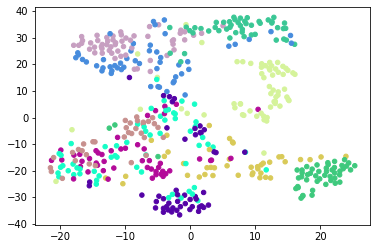

In [9]:
## visualize tSNE of original data
labels = y_test[random_select]
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#### tSNE of data after two hidden layers

Do visualization of the tSNE of data after going through MLP. In the visualization result, you should find that in comparison with the tSNE of original data where all data points mess up with each other, tSNE of data after two-layer networks would be shown as multiple clusters in a 2D panel.

In [10]:
# Define MLP model
model = MLP(input_dim=X_train.shape[1], hidden_dims=[100], num_classes=20, reg=0.1, weight_scale=1e-3)

num_epoch = 10
batch_size = 200
lr = 1e-3
verbose = False
train_acc_hist, val_acc_hist = train(model, X_train, y_train, X_val, y_val, 
                  num_epoch=num_epoch, batch_size=batch_size, learning_rate=lr, verbose=verbose)
test(model, X_test, y_test)

number of batches for training: 245
epoch 1: valid acc = 0.809, new learning rate = 0.00095
epoch 2: valid acc = 0.833, new learning rate = 0.0009025
epoch 3: valid acc = 0.846, new learning rate = 0.000857375
epoch 4: valid acc = 0.861, new learning rate = 0.0008145062499999999
epoch 5: valid acc = 0.871, new learning rate = 0.0007737809374999998
epoch 6: valid acc = 0.867, new learning rate = 0.0007350918906249997
epoch 7: valid acc = 0.879, new learning rate = 0.0006983372960937497
epoch 8: valid acc = 0.879, new learning rate = 0.0006634204312890621
epoch 9: valid acc = 0.882, new learning rate = 0.000630249409724609
epoch 10: valid acc = 0.871, new learning rate = 0.0005987369392383785
test acc: 0.8621


0.8621

<span style="color:red"><strong>TODO</strong></span>: Visualize data that is passed through MLP model defined above using tSNE. 

In [11]:
# run tSNE
X = X_test[random_select]
tic = time.time()

#############################################################################
#                          START OF YOUR CODE                               #
# Hint: Pass data through affine and dense layers (model.layers) and then 
# apply softmax to obtain output of the MLP model.
#############################################################################
def normalized_vec(x):
        x_max = np.max(x)
        x_exp = np.exp(x - x_max)
        x_row_sum = np.sum(x_exp, axis=1, keepdims=True)
        f = x_exp / x_row_sum
        return f

epsilon = 1e-15

for layer in model.layers:
    X = layer.feedforward(X)
X = normalized_vec(X) + epsilon
Y = tsne(X, low_dim=2, perplexity=30.0)
#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

print("it takes {} seconds".format(time.time()-tic))

0.13543497063306364
The 100 th loop cost: 8.30635827479799, computation time: 1.903806209564209
The 200 th loop cost: 0.20934358227484753, computation time: 3.775733709335327
The 300 th loop cost: 0.17585106357482147, computation time: 5.988745212554932
The 400 th loop cost: 0.16400057311603758, computation time: 7.9023518562316895
The 500 th loop cost: 0.15938799834759623, computation time: 9.982290744781494
The 600 th loop cost: 0.1567769852196414, computation time: 11.996803998947144
The 700 th loop cost: 0.1550336852209707, computation time: 13.92469334602356
The 800 th loop cost: 0.1537622949215033, computation time: 16.023608922958374
The 900 th loop cost: 0.15278065149052114, computation time: 18.313893795013428
The 1000 th loop cost: 0.1519954274887482, computation time: 20.487340450286865
it takes 21.262089729309082 seconds


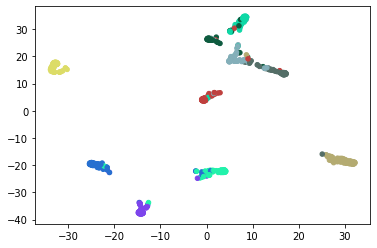

In [12]:
# visualize tSNE 2D representation of data after two hidden layers
#############################################################################
#                          START OF YOUR CODE                               #
# Hint: See tSNE visualization of original data
#############################################################################

labels = y_test[random_select]
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

<span style="color:red"><strong>TODO</strong></span>: Try tuning the parameters of tSNE, do visualization of the new tSNE of data.

In [13]:
# Tune the parameter, show the results.
# run tSNE
X = X_test[random_select]

#############################################################################
#                          START OF YOUR CODE                               #
#############################################################################
tic = time.time()

def normalized_vec(x):
        x_max = np.max(x)
        x_exp = np.exp(x - x_max)
        x_row_sum = np.sum(x_exp, axis=1, keepdims=True)
        f = x_exp / x_row_sum
        return f

epsilon = 1e-15

for layer in model.layers:
    X = layer.feedforward(X)
X = normalized_vec(X) + epsilon
Y = tsne(X, low_dim=2, perplexity=40.0)

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################

print("it takes {} seconds".format(time.time()-tic))

0.1989101785847638
The 100 th loop cost: 7.591010753530618, computation time: 1.9463121891021729
The 200 th loop cost: 0.16744564844452017, computation time: 4.1393883228302
The 300 th loop cost: 0.14460107659714153, computation time: 6.100206136703491
The 400 th loop cost: 0.1371172405463821, computation time: 8.186226606369019
The 500 th loop cost: 0.13461253942566231, computation time: 10.088272333145142
The 600 th loop cost: 0.1333484345234007, computation time: 12.070145606994629
The 700 th loop cost: 0.13255058235675518, computation time: 13.966021299362183
The 800 th loop cost: 0.1319886301714539, computation time: 16.08680272102356
The 900 th loop cost: 0.13156375921356084, computation time: 18.142334461212158
The 1000 th loop cost: 0.13122655496052252, computation time: 20.0902099609375
it takes 20.790184497833252 seconds


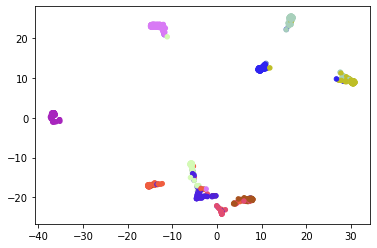

In [14]:
# visualize tSNE 2D representation of data after two hidden layers
#############################################################################
#                          START OF YOUR CODE                               #
#############################################################################

labels = y_test[random_select]
colors = np.random.rand(20,3)
color_labels = [colors[int(i)] for i in labels.tolist()]
plt.scatter(Y[:,0], Y[:,1], 20, color_labels)
plt.show()

#############################################################################
#                          END OF YOUR CODE                                 #
#############################################################################